In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the processed data
df = pd.read_csv('../data/diabetes_dataset_processed.csv')

In [3]:
def prepare_features(df):
    """
    Prepare features for modeling
    """
    # Separate numerical and categorical columns
    numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'cardiovascular_risk']
    categorical_cols = ['gender', 'smoking_history', 'bmi_category', 'HbA1c_category', 'glucose_category']
    
    # Create feature matrix
    X_num = df[numerical_cols].copy()
    X_cat = df[categorical_cols].copy()
    
    # Scale numerical features
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num)
    X_num_scaled = pd.DataFrame(X_num_scaled, columns=numerical_cols)
    
    # Encode categorical features
    encoders = {}
    X_cat_encoded = pd.DataFrame()
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_cat_encoded[col] = le.fit_transform(X_cat[col])
        encoders[col] = le
    
    # Combine features
    X = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
    y = df['diabetes']
    
    return X, y, encoders, scaler

In [4]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model performance with multiple metrics
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    return results, y_pred, y_pred_proba

In [7]:
# Prepare the data
X, y, encoders, scaler = prepare_features(df)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [9]:
# Train and evaluate models
results_list = []
model_predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    results, y_pred, y_pred_proba = evaluate_model(model, X_test, y_test, name)
    results_list.append(results)
    model_predictions[name] = {'pred': y_pred, 'proba': y_pred_proba}
    
    # Print detailed classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))


Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     18292
           1       0.76      0.41      0.54      1708

    accuracy                           0.94     20000
   macro avg       0.85      0.70      0.75     20000
weighted avg       0.93      0.94      0.93     20000


Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     18292
           1       0.82      0.57      0.68      1708

    accuracy                           0.95     20000
   macro avg       0.89      0.78      0.83     20000
weighted avg       0.95      0.95      0.95     20000


Training XGBoost...


/home/calvin/mlzoomcamp/.venv/lib64/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:16:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     18292
           1       0.89      0.60      0.72      1708

    accuracy                           0.96     20000
   macro avg       0.93      0.80      0.85     20000
weighted avg       0.96      0.96      0.96     20000



In [10]:
# Create results DataFrame
results_df = pd.DataFrame(results_list)
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                 Model  Accuracy  Precision    Recall        F1   ROC_AUC
0  Logistic Regression   0.93880   0.760215  0.413934  0.536012  0.943884
1        Random Forest   0.95320   0.823826  0.574941  0.677241  0.957245
2              XGBoost   0.95935   0.888118  0.599532  0.715834  0.970273


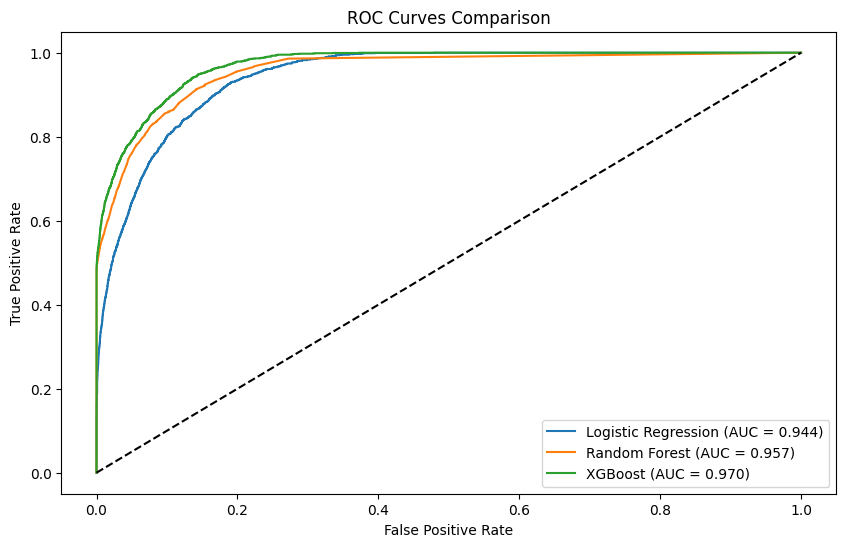

In [11]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
for name in models.keys():
    y_pred_proba = model_predictions[name]['proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

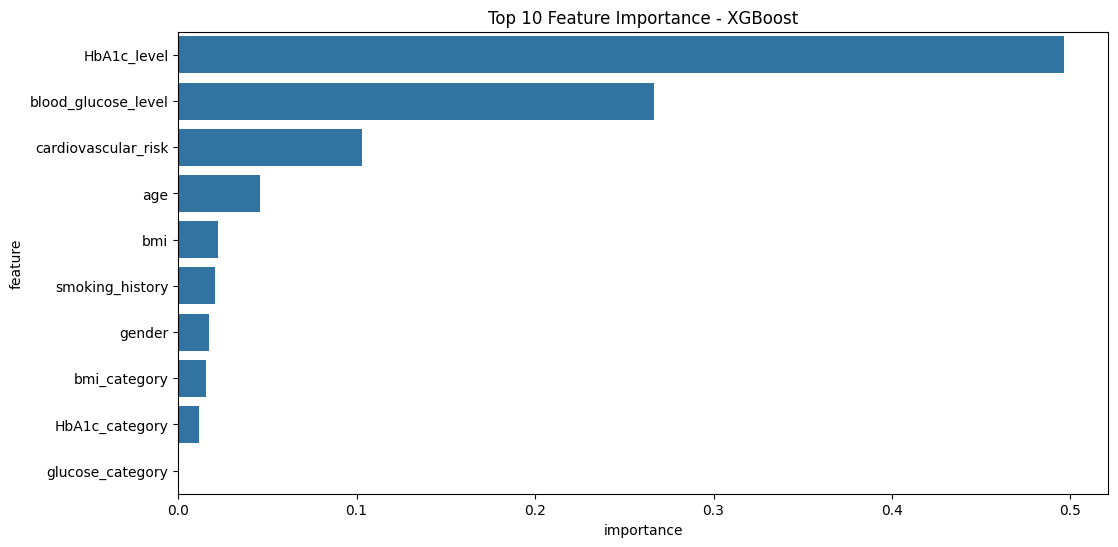

In [12]:
# Feature importance analysis for the best model (assuming Random Forest or XGBoost performs best)
best_model_name = results_df.sort_values('ROC_AUC', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]

if best_model_name in ['Random Forest', 'XGBoost']:
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.show()